# The problem

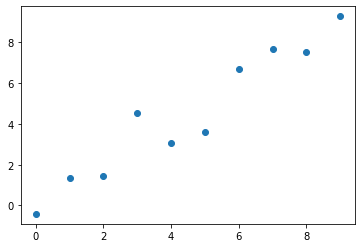

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def create_linear_regression_data():
    x = np.arange(0, 10, 1)
    y = x + np.random.normal(0, 1, 10)
    
    return [x, y]

linear_regression_data = create_linear_regression_data()

plt.scatter(
    linear_regression_data[0],
    linear_regression_data[1],
);

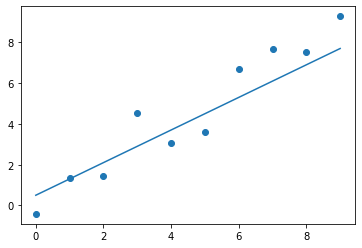

In [29]:
def plot_guess(k, b):
    x = np.arange(0, 10, 1)
    y = k * x + b

    plt.scatter(
        linear_regression_data[0],
        linear_regression_data[1],
    )

    plt.plot(x, y)

plot_guess(0.8, 0.5)

## Gradient Descent for Linear Regression

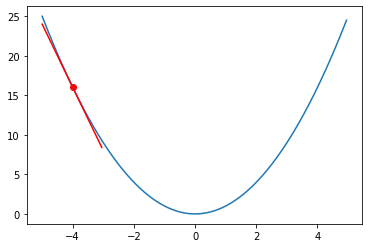

In [35]:
def plot_quadratic():
    # plot quadratic
    x = np.arange(-5, 5, 0.05)
    y = x ** 2

    plt.plot(x, y)
    
    # plot the gradient at -4 
    x_grad_point = -4
    
    plt.scatter(x_grad_point, x_grad_point ** 2, c='r')
    
    k_grad = 2 * x_grad_point
    b_grad = x_grad_point ** 2 - k_grad * x_grad_point

    x_grad = np.arange(x_grad_point - 1, x_grad_point + 1, 0.05)
    y_grad = k_grad * x_grad + b_grad
    
    plt.plot(x_grad, y_grad, c='r')

plot_quadratic()

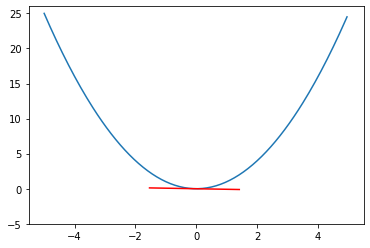

In [77]:
import time
from matplotlib import animation, rc

rc('animation', html='html5')

def animate_quadratic_gradient_descent():
    fig, ax = plt.subplots()

    ax.set_xlim((-5.5, 5.5))
    ax.set_ylim((-5, 26))
    
    # plot the quadratic function
    q_x = np.arange(-5, 5, 0.05)
    q_y = q_x ** 2

    ax.plot(q_x, q_y);
    
    # define the gradient line
    g_line, = ax.plot([], [], c='r')

    a = 0.05
    c = -4
    
    def init():
        nonlocal c
        
        c = -4

    def animate(i):
        nonlocal c

        k_grad = 2 * c
        b_grad = c ** 2 - k_grad * c

        x_grad = np.arange(c - 1.5, c + 1.5, 0.05)
        y_grad = k_grad * x_grad + b_grad

        g_line.set_data(x_grad, y_grad)
        
        c -= a * 2 * c

    return animation.FuncAnimation(fig, animate, init_func=init, frames=45, interval=60)

quadratic_animation = animate_quadratic_gradient_descent()
quadratic_animation

In [78]:
quadratic_animation.save(
    './media/quadratic-gradient-descent-animation.gif',
    writer='imagemagick',
)

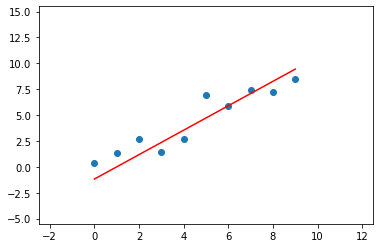

In [138]:
def animate_linear_regression_gradient_descent():
    fig, ax = plt.subplots()

    ax.set_xlim((-2.5, 12.5))
    ax.set_ylim((-5.5, 15.5))

    # plot the data scatter plot
    x = np.arange(0, 10, 1)
    y = x + np.random.normal(0, 1, 10)
    
    ax.scatter(x, y)
    
    line, = ax.plot([], [], c='r')
    
    # initialise our initial guess
    alpha = 0.003

    k = 0.25
    b = -5

    def init():
        nonlocal k, b
        
        k = 0.25
        b = -5
    
    def animate(i):
        nonlocal alpha, k, b

        x_line = np.arange(0, 10, 1)
        y_line = k * x_line + b

        line.set_data(x_line, y_line)
        
        # do the update step
        n = len(x)

        k_grad = -2 / n * np.sum(x * (y - y_line))
        b_grad = -2 / n * np.sum(y - y_line)

        k -= alpha * k_grad
        b -= 10 * alpha * b_grad

    return animation.FuncAnimation(fig, animate, init_func=init, frames=60, interval=60)

linear_regression_animation = animate_linear_regression_gradient_descent()
linear_regression_animation

In [139]:
linear_regression_animation.save(
    './media/linear-regression-gradient-descent-animation.gif',
    writer='imagemagick',
)

# Implementing a Neural Network
---

In [243]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

First of all, it would be nice to be able to test our analytical solutions for the gradients. Lucky for us, we can do this very easily by implementing a method for computing numerical gradients w.r.t. to some input `x`.

In [245]:
def numerical_gradient(func, x, eps=1e-4):
    """
    Computes the numerical gradient of function `func` at point `x`.
    
    Args:
        func : A function of which gradient to compute.
        x    : The point to compute the gradient at. Must be a one-dimensional array.

    Returns:
        g : The gradient at point `x`.
    """
    e = np.zeros_like(x)
    f = func(x)
    g = np.zeros((f.size, x.size))

    for i in range(len(x)):
        e[:] = 0
        e[i] = 1

        f1, f2 = func(x + e * eps), func(x - e * eps)
        g[:, i] = (f1 - f2) / (2 * eps)

    return g

## Mean Square Error Loss Function
---

The first step in implementing the neural network is implementing the loss function. As described in the blog post, we will be using a Mean Square Error loss function.

For training purposes, we will implement each block of the neural network as a class with at least the following two methods:

- `forward`
- `backward`

The equation for the Mean Square Error loss function is

$$
c = \frac{1}{n} \sum_{i = 1}^{n} (y_i - \hat{y_i})^2 
$$

and therefore the gradient w.r.t. $y$ is

$$
\frac{\partial c}{\partial y} = \frac{2}{n} \sum_{i = 1}^{n} (y_i - \hat{y_i})
$$

In [246]:
class MSELoss:
    def forward(self, y, target):
        """
        Computes the loss of each entry in the batch.
        
        Args:
            y      : The actual output from the neural network. Shape of (batch_size, out_features)
            target : The real target. Shape of (batch_size, out_features)
        
        Returns:
            c : The loss of each entry in the batch. Shape of (batch_size, 1)
        """

        # Note: Keep the differences for the gradient computation
        self.diff = y - target
        return np.sum(np.square(self.diff)) / self.diff.size

    def backward(self):
        """
        Computes the gradient of the loss w.r.t. output of the network's last layer.
        
        Returns:
            dy : The gradient of the loss w.r.t. to `y`. Shape of (batch_size, out_features)
        """

        return 2 / np.prod(self.diff.shape) * self.diff

We can now test the MSE loss gradient computations using the numerical gradient we defined earlier.

In [253]:
def test_MSELoss_backward():
    y = np.random.randn(2, 3)
    target = np.zeros((2, 3))

    loss = MSELoss()
    loss_value = loss.forward(y, target)

    dy = loss.backward()

    dy_num = numerical_gradient(lambda y: loss.forward(y.reshape((2, 3)), target), y.flatten())
    dy_num = dy_num[0].reshape((2, 3))

    print('Analytical gradient:\n', dy)
    print('')
    print('Numerical gradient:\n', dy_num)

test_MSELoss_backward()

Analytical gradient:
 [[-0.09066233  0.28466172 -0.19194509]
 [-0.31350072  0.45449091 -0.09285234]]

Numerical gradient:
 [[-0.09066233  0.28466172 -0.19194509]
 [-0.31350072  0.45449091 -0.09285234]]


## ReLU Activation Function
---

Next, we will do the same for the activation function. We'll be using ReLU activation function but there are bunch of other ones that could be as well.

In [254]:
class ReLU:
    def forward(self, x):
        """
        Applies the ReLU activation function.

        Args:
            x : Output from the previous layer. Shape of (batch_size, features)

        Returns:
            y : Input after the activation function. Shape of (batch_size, features)
        """

        self.x = x
        return np.maximum(x, np.zeros(x.shape))

    def backward(self, dy):
        """
        Args:
            dy : Gradient of the loss w.r.t. `y`. Shape of (batch_size, features)

        Returns:
            dx : Gradient of the loss w.r.t. `x`. Shape of (batch_size, features)
        """

        return np.where(
            self.x > 0,
            np.ones(self.x.shape),
            np.zeros(self.x.shape)
        ) * dy

Let's do a similar test for ReLU as we did for MSE loss.

In [262]:
def test_ReLU_forward():
    x = np.array([1, -1, 0])
    y = ReLU().forward(x)
    
    print('Output:\n', y)
    print('')
    print('Expected:\n', np.array([1, 0, 0], dtype=np.float64))

test_ReLU_forward()

Output:
 [1. 0. 0.]

Expected:
 [1. 0. 0.]


In [263]:
def test_ReLU_backward():
    # The network is x --> ReLU --> MSELoss
    x = np.random.randn(2, 3)
    target = np.zeros((2, 3))

    relu = ReLU()
    loss = MSELoss()

    loss_value = loss.forward(relu.forward(x), target)

    dx = relu.backward(loss.backward())

    dx_num = numerical_gradient(lambda x: loss.forward(relu.forward(x.reshape((2, 3))), target), x.flatten())
    dx_num = dx_num[0].reshape((2, 3))

    print('Analytical gradient:\n', dx)
    print('')
    print('Numerical gradient:\n', dx_num)

test_ReLU_backward()

Analytical gradient:
 [[0.20215038 0.08954542 0.13159422]
 [0.09739404 0.         0.        ]]

Numerical gradient:
 [[0.20215038 0.08954542 0.13159422]
 [0.09739404 0.         0.        ]]


In [310]:
class Tanh:
    def forward(self, x):
        """
        Args:
          x (array): Input of shape (batch_size, xsize).
        
        Returns:
          y (array): Output of shape (batch_size, xsize).
        """
        self.x = x
        # YOUR CODE HERE
        return np.tanh(x)

    def backward(self, dy):
        """
        Args:
          dy (array): Gradient of a loss wrt outputs, shape (batch_size, xsize).
        
        Returns:
          dx (array): Gradient of a loss wrt inputs, shape (batch_size, xsize).
        """
        assert hasattr(self, 'x'), "Need to call forward() first."
        # YOUR CODE HERE
        return (1 - np.tanh(self.x) ** 2) * dy

# Linear Layer
---

Next, the most important component, the linear layer.

In [291]:
class Linear:
    def __init__(self, in_features, out_features):
        # Initialise the internal weights and biases
        bound_W = 3 / np.sqrt(in_features)
        bound_b = 1 / np.sqrt(in_features)

        self.W = np.random.uniform(-bound_W, bound_W, (out_features, in_features))
        self.b = np.random.uniform(-bound_b, bound_b, (out_features))
        
        # Initialise the internal gradients
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x, W = None, b = None):
        """
        Does the forward W^T x + b computation.

        Args:
          x : Inputs of shape (batch_size, in_features).
          W : Weights of shape (out_features, in_features).
          b : Bias terms of shape (out_features).

        Returns:
          y (array): Outputs of shape (batch_size, out_features).
        """
        
        _W = self.W if W is None else W
        _b = self.b if b is None else b

        self.x = x

        return x @ _W.T + _b.T

    def backward(self, dy):
        """
        Args:
            dy : Gradient of the loss w.r.t. `y`. Shape of (batch_size, out_features)

        Returns:
            dx : Gradient of the loss w.r.t. `x`. Shape of (batch_size, in_features)
        """

        dx = dy @ self.W

        self.dW = dy.T @ self.x
        self.db = np.sum(dy.T, axis=1)

        return dx

In [298]:
def test_Linear_backward():
    batch_size, in_features, out_features = 3, 5, 3
    
    # Define the network
    loss_fn = MSELoss()
    act_fn = ReLU()
    linear = Linear(in_features, out_features)

    x = np.random.randn(batch_size, in_features)
    target = np.zeros((batch_size, out_features))
    
    W = linear.W.copy()
    b = linear.b.copy()
    
    # Do the forward pass
    c = loss_fn.forward(act_fn.forward(linear.forward(x)), target)
    
    # Do the backward pass
    dx = linear.backward(act_fn.backward(loss_fn.backward()))
    
    # Compute the numerical gradients

    # dx
    dx_num = numerical_gradient(
        lambda x: loss_fn.forward(
            act_fn.forward(
                linear.forward(x.reshape((batch_size, in_features)))
            ),
            target
        ),
        x.flatten()
    )
    
    dx_num = dx_num[0].reshape((batch_size, in_features))
    
    print('Analytical dx:\n', dx, '\n\n', 'Numerical dx:\n', dx_num, '\n')    
    assert np.allclose(dx, dx_num), 'Analytical and numerical dx differ'
    
    # dW
    dW_num = numerical_gradient(
        lambda W: loss_fn.forward(
            act_fn.forward(
                linear.forward(x, W.reshape((out_features, in_features)), b)
            ),
            target
        ),
        W.flatten()
    )
    
    dW_num = dW_num[0].reshape((out_features, in_features))
    
    print('Analytical dW:\n', linear.dW, '\n\n', 'Numerical dW:\n', dW_num, '\n')
    assert np.allclose(linear.dW, dW_num), 'Analytical and numerical dW differ'
    
    # db
    db_num = numerical_gradient(
        lambda b: loss_fn.forward(
            act_fn.forward(
                linear.forward(x, W, b)
            ),
            target
        ),
        b
    )

    print('Analytical db:\n', linear.db, '\n\n', 'Numerical db:\n', db_num, '\n')
    assert np.allclose(linear.db, db_num), 'Analytical and numerical db differ'

    print('Success')

test_Linear_backward()

Analytical dx:
 [[-3.82897148e-02  5.87216539e-02 -1.38880414e-01  6.37142744e-02
  -9.75234231e-02]
 [-1.26818759e-01  3.04363633e-01 -5.57385203e-01  2.24238407e-01
  -3.92430831e-01]
 [-2.65978506e-04 -3.97381207e-04  4.68433548e-04 -1.24226172e-04
  -1.59859764e-04]] 

 Numerical dx:
 [[-3.82897148e-02  5.87216539e-02 -1.38880414e-01  6.37142744e-02
  -9.75234231e-02]
 [-1.26818759e-01  3.04363633e-01 -5.57385203e-01  2.24238407e-01
  -3.92430831e-01]
 [-2.65978506e-04 -3.97381207e-04  4.68433548e-04 -1.24226172e-04
  -1.59859764e-04]] 

Analytical dW:
 [[ 1.61006581e-04 -3.44734114e-04  1.37314020e-04  1.35986555e-04
   6.68939156e-04]
 [-3.44895131e-02  1.34858149e-02 -9.97059002e-02  4.11387039e-03
   5.30780918e-02]
 [-3.86357431e-01  1.53900195e-01 -8.18923446e-01  1.21081111e-01
   5.03077402e-01]] 

 Numerical dW:
 [[ 1.61006581e-04 -3.44734114e-04  1.37314020e-04  1.35986555e-04
   6.68939155e-04]
 [-3.44895131e-02  1.34858149e-02 -9.97059002e-02  4.11387039e-03
   5.307809

## Constructing the network
---

In [311]:
class MLP:
    def __init__(self, in_features, hidden_1_size, hidden_2_size, out_features):
        self.fc1 = Linear(in_features, hidden_1_size)
        self.activation_fn1 = Tanh()
        self.fc2 = Linear(hidden_1_size, hidden_2_size)
        self.activation_fn2 = Tanh()
        self.fc3 = Linear(hidden_2_size, out_features)

    def forward(self, x):
        y = self.fc1.forward(x)
        y = self.activation_fn1.forward(y)
        y = self.fc2.forward(y)
        y = self.activation_fn2.forward(y)
        y = self.fc3.forward(y)

        return y

    def backward(self, dy):
        dx = self.fc3.backward(dy)
        dx = self.activation_fn2.backward(dx)
        dx = self.fc2.backward(dx)
        dx = self.activation_fn1.backward(dx)
        dx = self.fc1.backward(dx)
        
        return dx

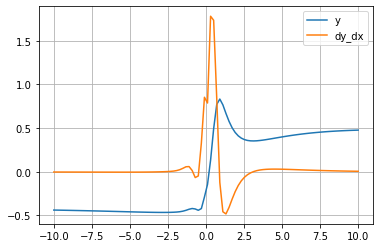

In [312]:
batch_size = 100
x = np.linspace(-10, 10, batch_size)
mlp = MLP(1, 10, 20, 1)
y = mlp.forward(x.reshape((batch_size, 1))).flatten()

dy_dx = mlp.backward(np.ones((batch_size, 1))).flatten()

fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, dy_dx)
ax.grid(True)
ax.legend(['y', 'dy_dx'])

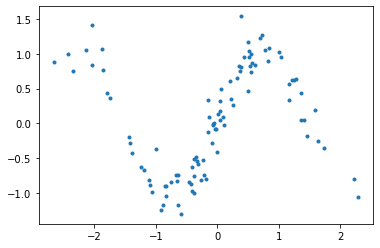

In [313]:
# Let us generate toy data
np.random.seed(2)
x = np.random.randn(100, 1)
x = np.sort(x, axis=0)
targets = np.sin(x * 2 * np.pi / 3)
targets = targets + 0.2 * np.random.randn(*targets.shape)

# Plot the data
fig, ax = plt.subplots(1)
ax.plot(x, targets, '.')

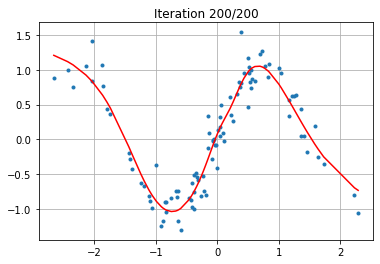

In [327]:
# And train an MLP network using gradient descent
from IPython import display

skip_training = False

if not skip_training:  # The trained MLP is not tested
    mlp = MLP(1, 10, 10, 1)  # Create MLP network
    loss = MSELoss()  # Create loss

    fig, ax = plt.subplots(1)
    ax.plot(x, targets, '.')
    learning_rate = 0.075
    n_epochs = 1 if skip_training else 200
    for i in range(n_epochs):
        # Forward computations
        y = mlp.forward(x)
        c = loss.forward(y, targets)

        # Backward computations
        dy = loss.backward()
        dx = mlp.backward(dy)

        # Gradient descent update
        learning_rate *= 0.998  # Learning rate annealing
        for module in mlp.__dict__.values():
            if hasattr(module, 'W'):
                module.W = module.W - module.dW * learning_rate
                module.b = module.b - module.db * learning_rate

        ax.clear()
        ax.plot(x, targets, '.')
        ax.plot(x, y, 'r-')
        ax.grid(True)
        ax.set_title('Iteration %d/%d' % (i+1, n_epochs))
        display.clear_output(wait=True)
        display.display(fig)
        plt.pause(0.005)
    display.clear_output(wait=True)